In [1]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import impulse, lti, step, butter, lfilter, welch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize

# Import data

In [2]:
df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# Plot raw data

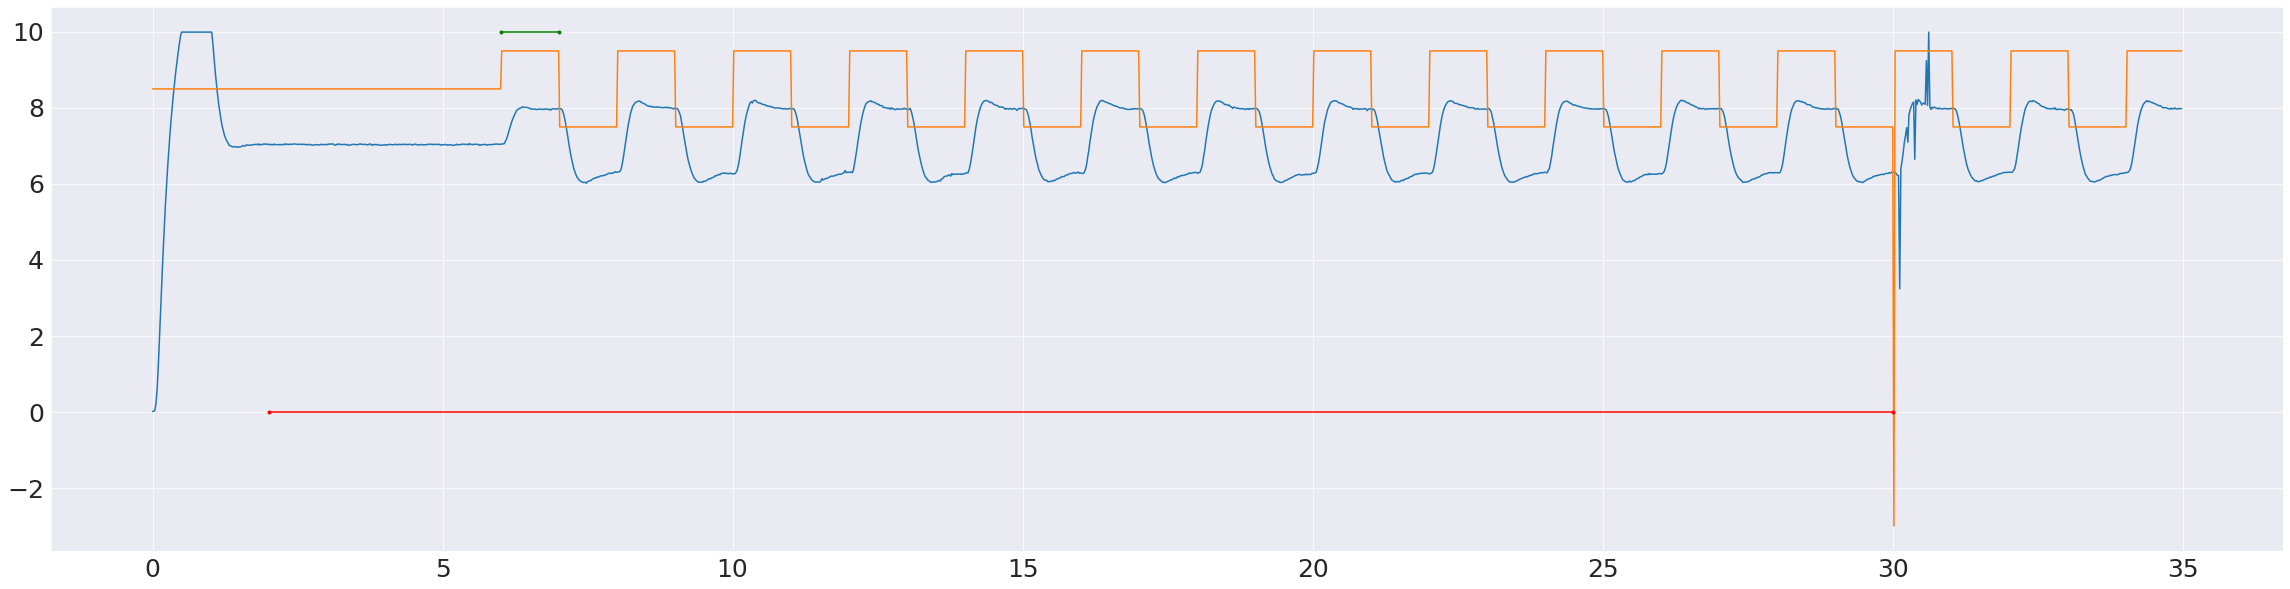

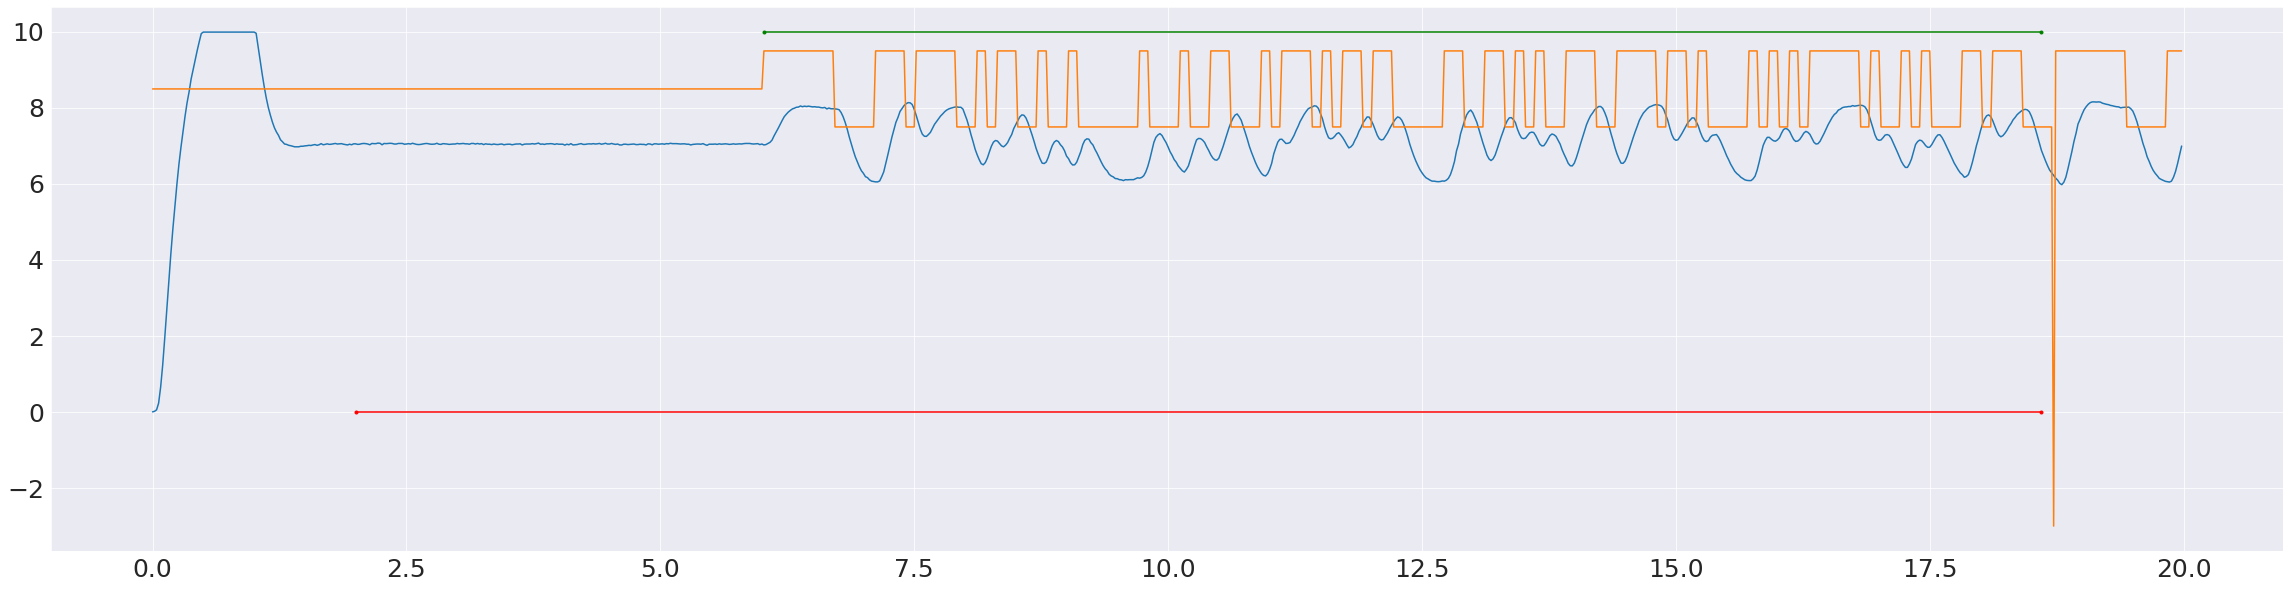

In [3]:
plt.figure(figsize=(40,10))
plt.plot(df1['time'],df1['y'])
plt.plot(df1['time'],df1['u'])
plt.plot([df1['time'][100],df1['time'][1500]],[0,0],'r', marker='.')
plt.plot([df1['time'][300],df1['time'][350]],[10,10],'g', marker='.')
plt.grid(True)
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df2['time'],df2['y'])
plt.plot(df2['time'],df2['u'])
plt.plot([df2['time'][100],df2['time'][930]],[0,0],'r', marker='.')
plt.plot([df2['time'][301],df2['time'][930]],[10,10],'g', marker='.')
plt.grid(True)
plt.show()

# Reformat data
## (Cut and z-normalize)

/tmp/ipykernel_588/2653185600.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_588/2653185600.py:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_588/2653185600.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_588/2653185600.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are igno

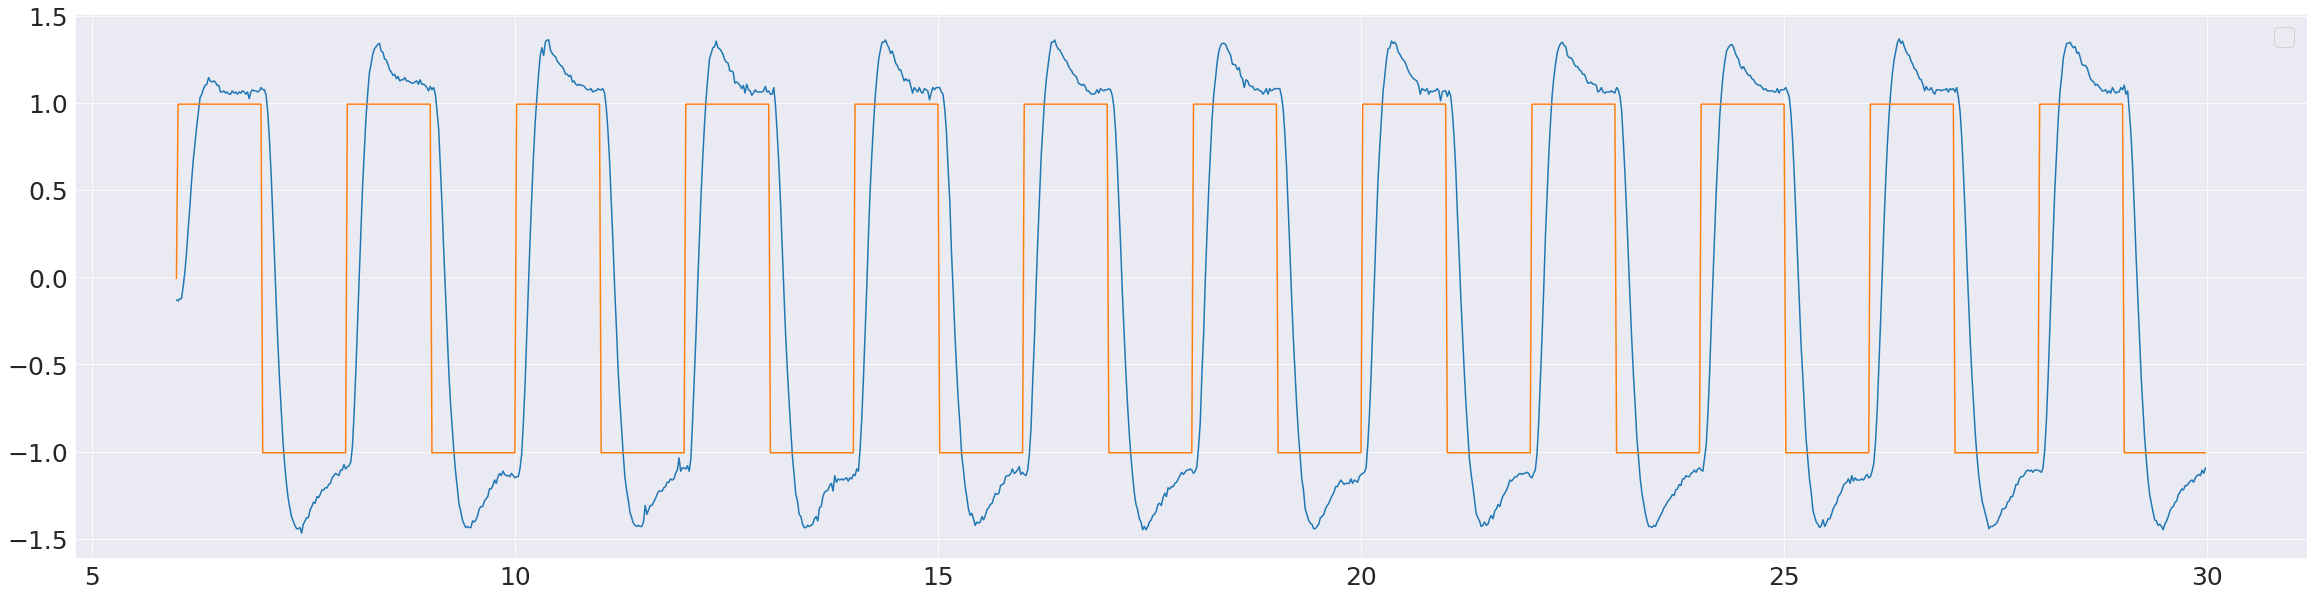

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


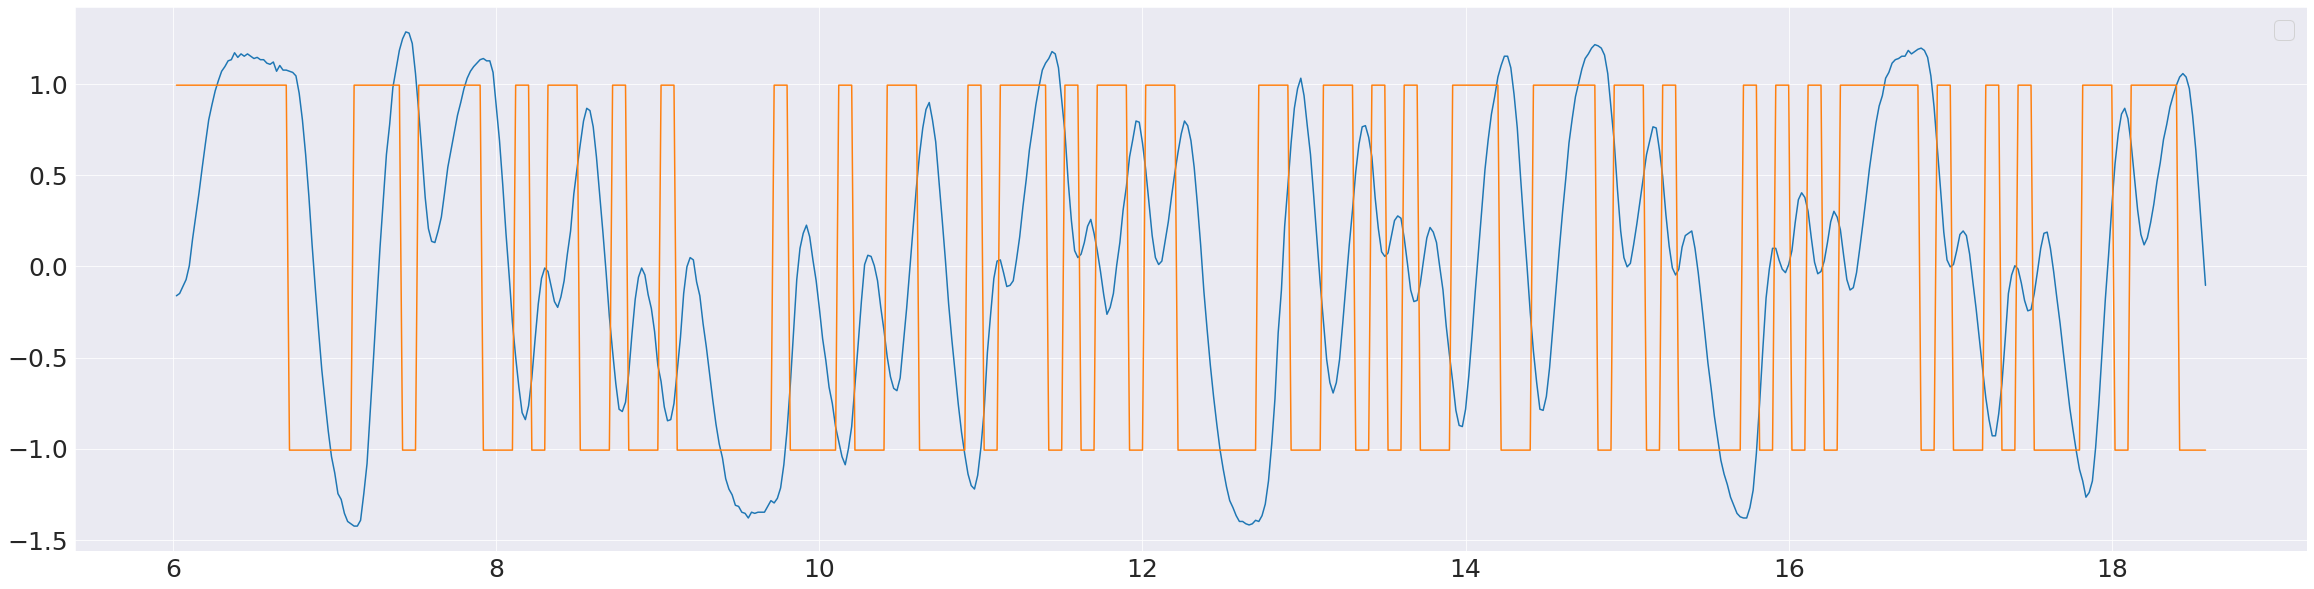

In [4]:
# cut
df1 = df1.iloc[300:1500]
df2 = df2.iloc[301:930]

# z-normalise
# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

plt.figure(figsize=(40,10))
plt.plot(df1['time'],df1['y'])
plt.plot(df1['time'],df1['u'])
plt.grid(True)
plt.legend()
plt.show()
plt.figure(figsize=(40,10))
plt.plot(df2['time'],df2['y'])
plt.plot(df2['time'],df2['u'])
plt.grid(True)
plt.legend()
plt.show()

### Any additional data prefiltering (s.a. smoothing,..)?

# Fourier space (of PRBS)

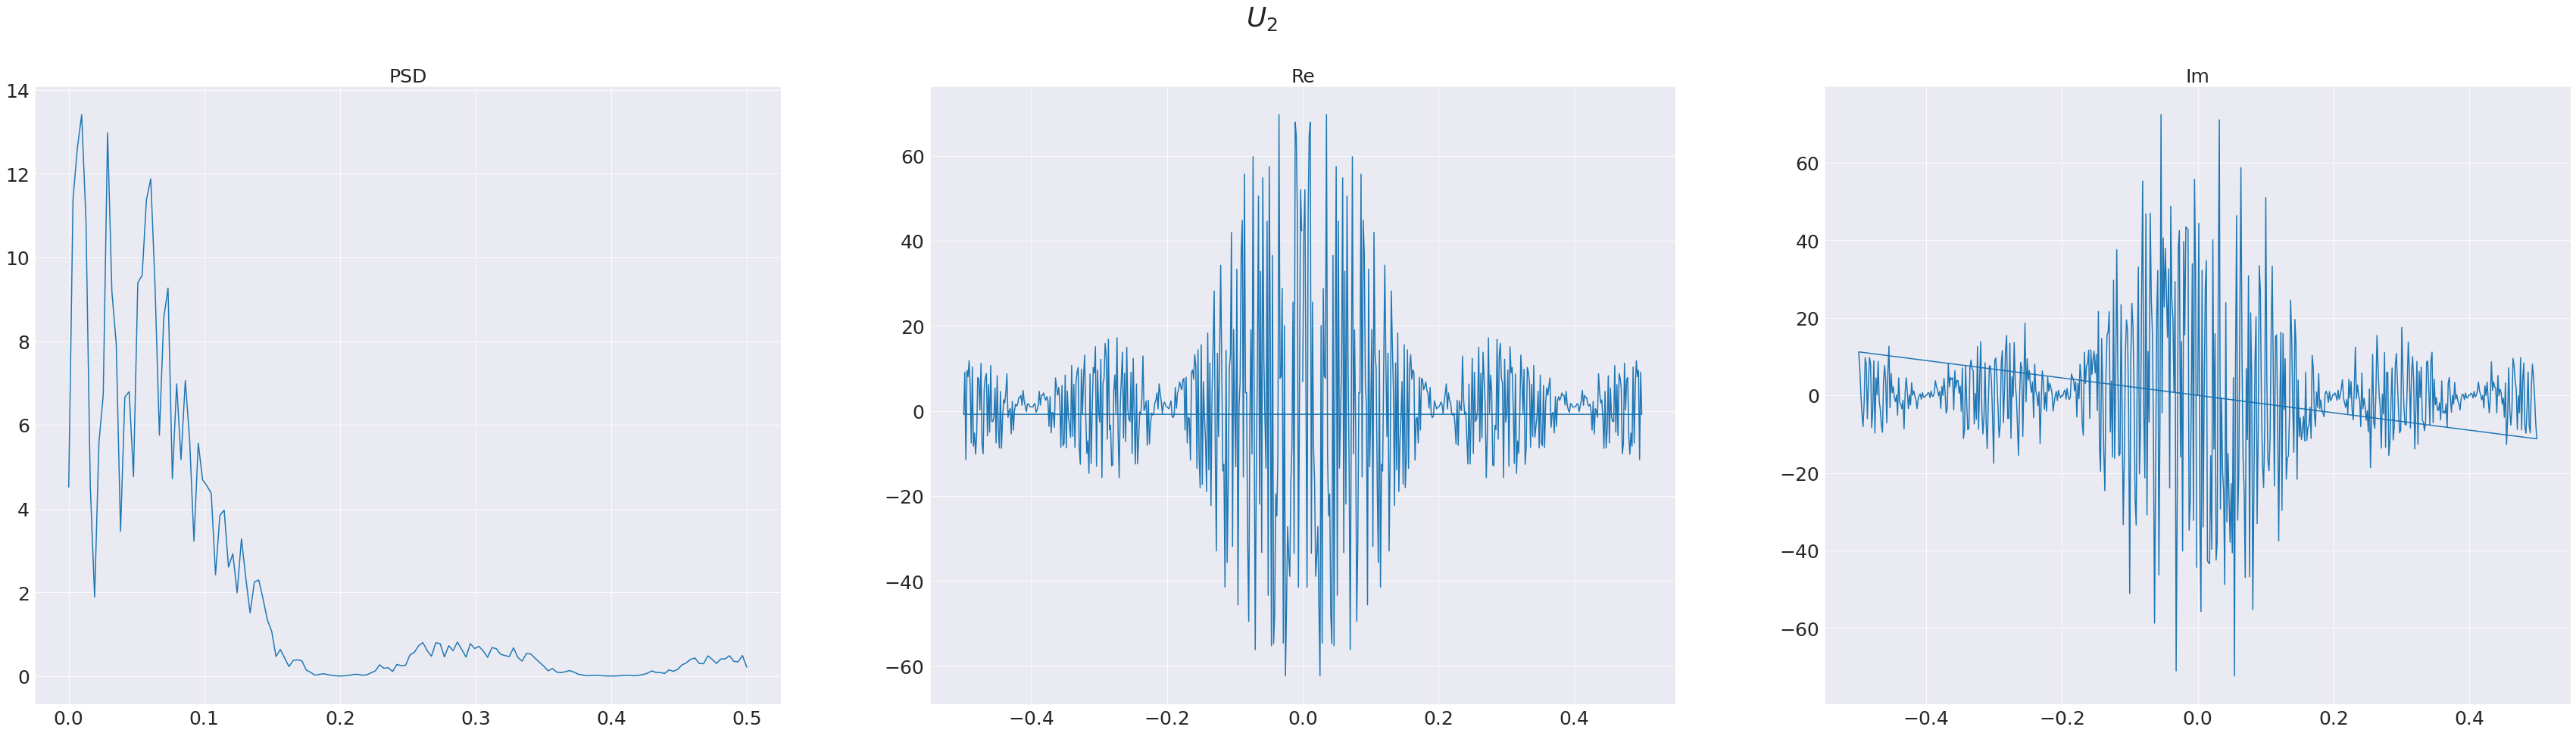

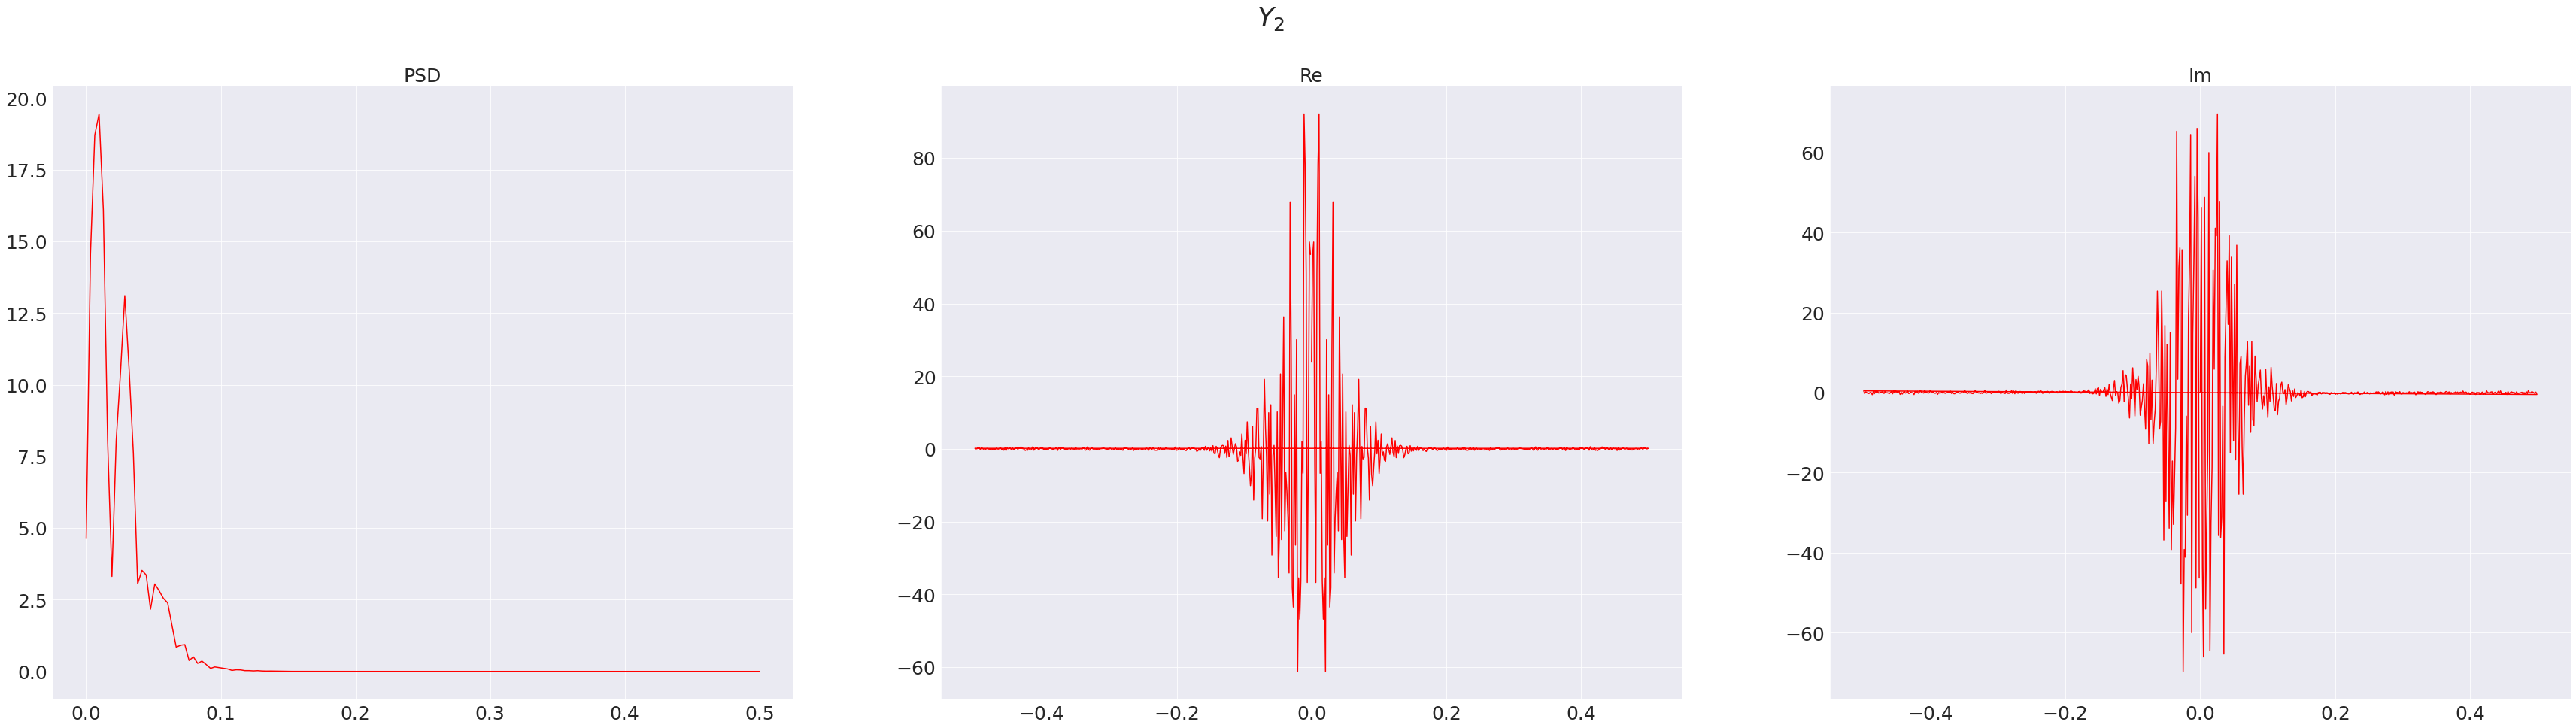

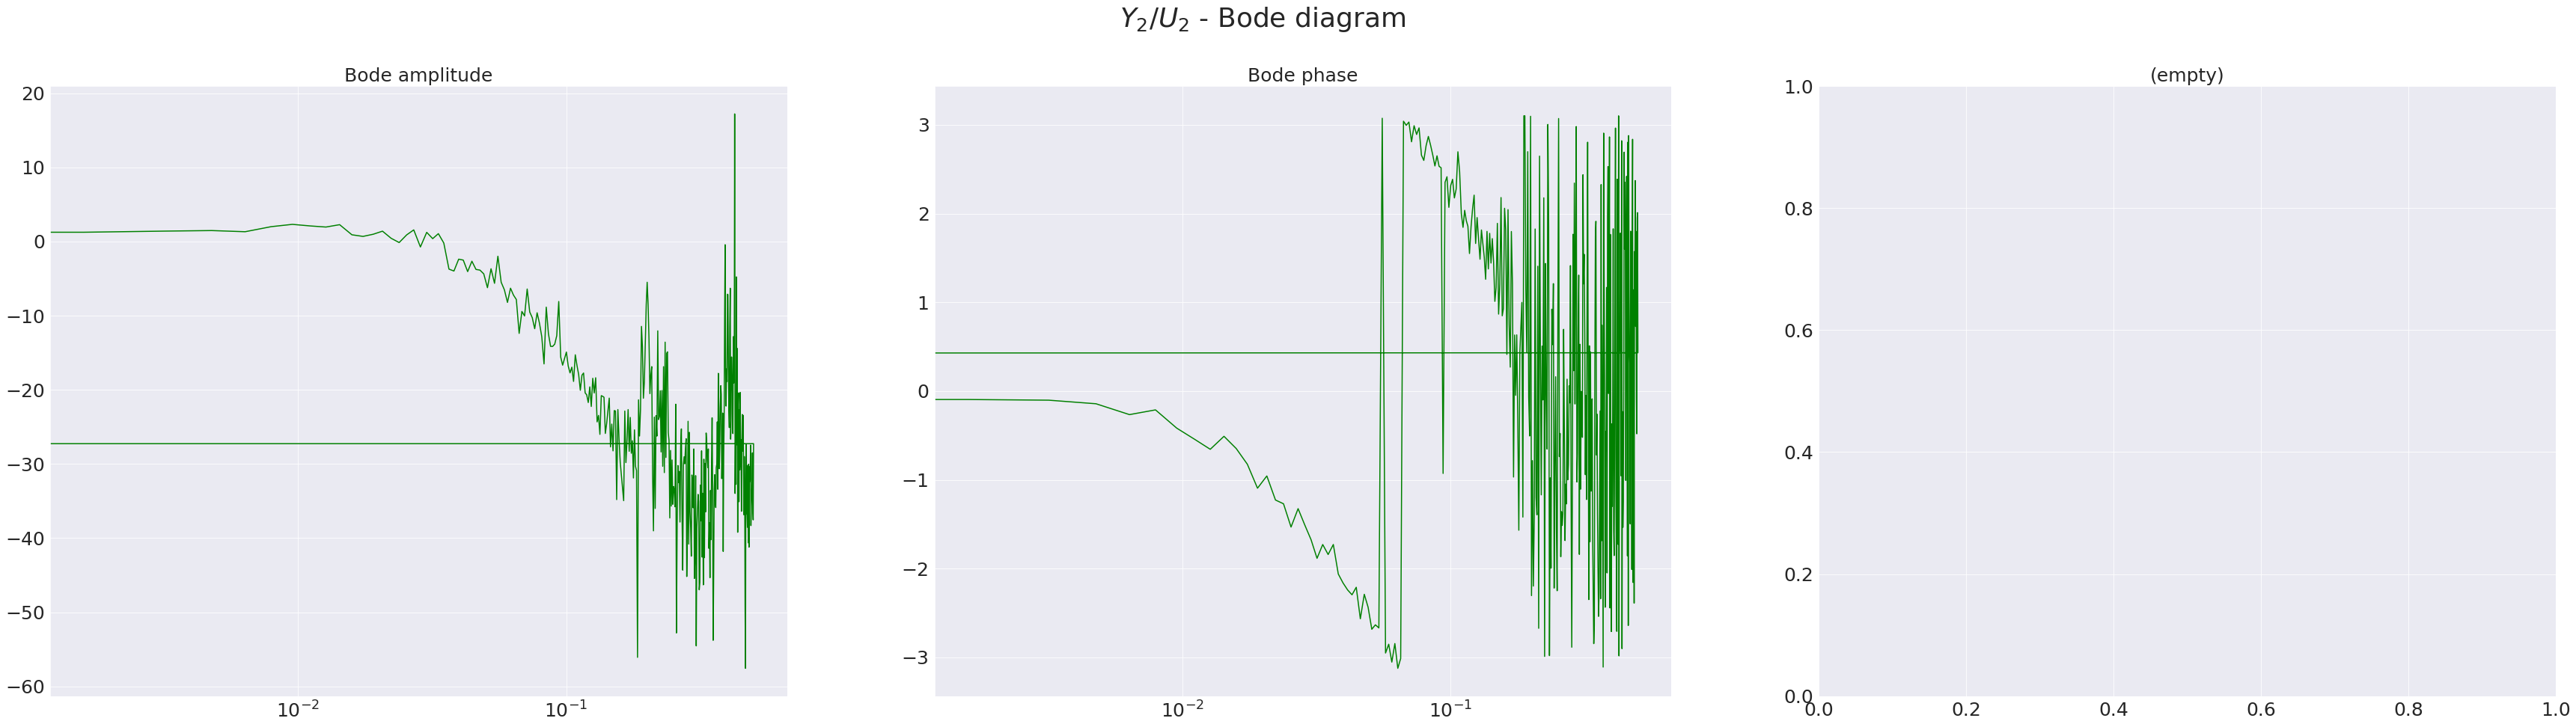

In [15]:
fs = 1 # define sampling frequency to be 1
freqs = np.fft.fftfreq(len(df2['u']), 1)

fig, axn = plt.subplots(1,3,figsize=(60,15))
fig.suptitle(r'$U_2$')
f, psd_u = welch(df2['u'], fs, nperseg=len(df2['u'])//2)
ft_u = np.fft.fft(df2['u'])
axn[0].plot(f, psd_u)
axn[1].plot(freqs, np.real(ft_u))
axn[2].plot(freqs, np.imag(ft_u))
axn[0].set_title('PSD')
axn[1].set_title('Re')
axn[2].set_title('Im')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
plt.show()

fig, axn = plt.subplots(1,3,figsize=(60,15))
fig.suptitle(r'$Y_2$')
f, psd_y = welch(df2['y'], fs, nperseg=len(df2['y'])//2)
ft_y = np.fft.fft(df2['y'])
axn[0].plot(f, psd_y, c='r')
axn[1].plot(freqs, np.real(ft_y), c='r')
axn[2].plot(freqs, np.imag(ft_y), c='r')
axn[0].set_title('PSD')
axn[1].set_title('Re')
axn[2].set_title('Im')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
plt.show()

fig, axn = plt.subplots(1,3,figsize=(60,15))
fig.suptitle(r'$Y_2/U_2$ - Bode diagram')
ft_G = ft_y / ft_u
axn[0].semilogx(freqs, 20 * np.log10(np.abs(ft_G)), c='g')
axn[1].semilogx(freqs, np.angle(ft_G), c='g')
axn[0].set_title('Bode amplitude')
axn[1].set_title('Bode phase')
axn[2].set_title('(empty)')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
plt.show()

### The slope of the Bode diagram approximately follows the -40dB per  decade for higher frequencies which indicates a system of second order. So does the phase transition from $0$ to $-\pi$.

# Is the process stationary? - Dicky-Fuller test

In [6]:
adfuller(df2['y'])

(-4.624963164918656,
 0.00011615497838071354,
 13,
 615,
 {'1%': -3.4410277306083668,
  '5%': -2.8662510413264357,
  '10%': -2.569278890210853},
 -2256.2957520854634)

### The p-value (second entry) < 0.05 - the null hypothesis (process has a unit root) is rejected - the process is stationary

### Plot ACF and PACF to determine the order of AR and MA (respectively) part of the model

/home/kreljo/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


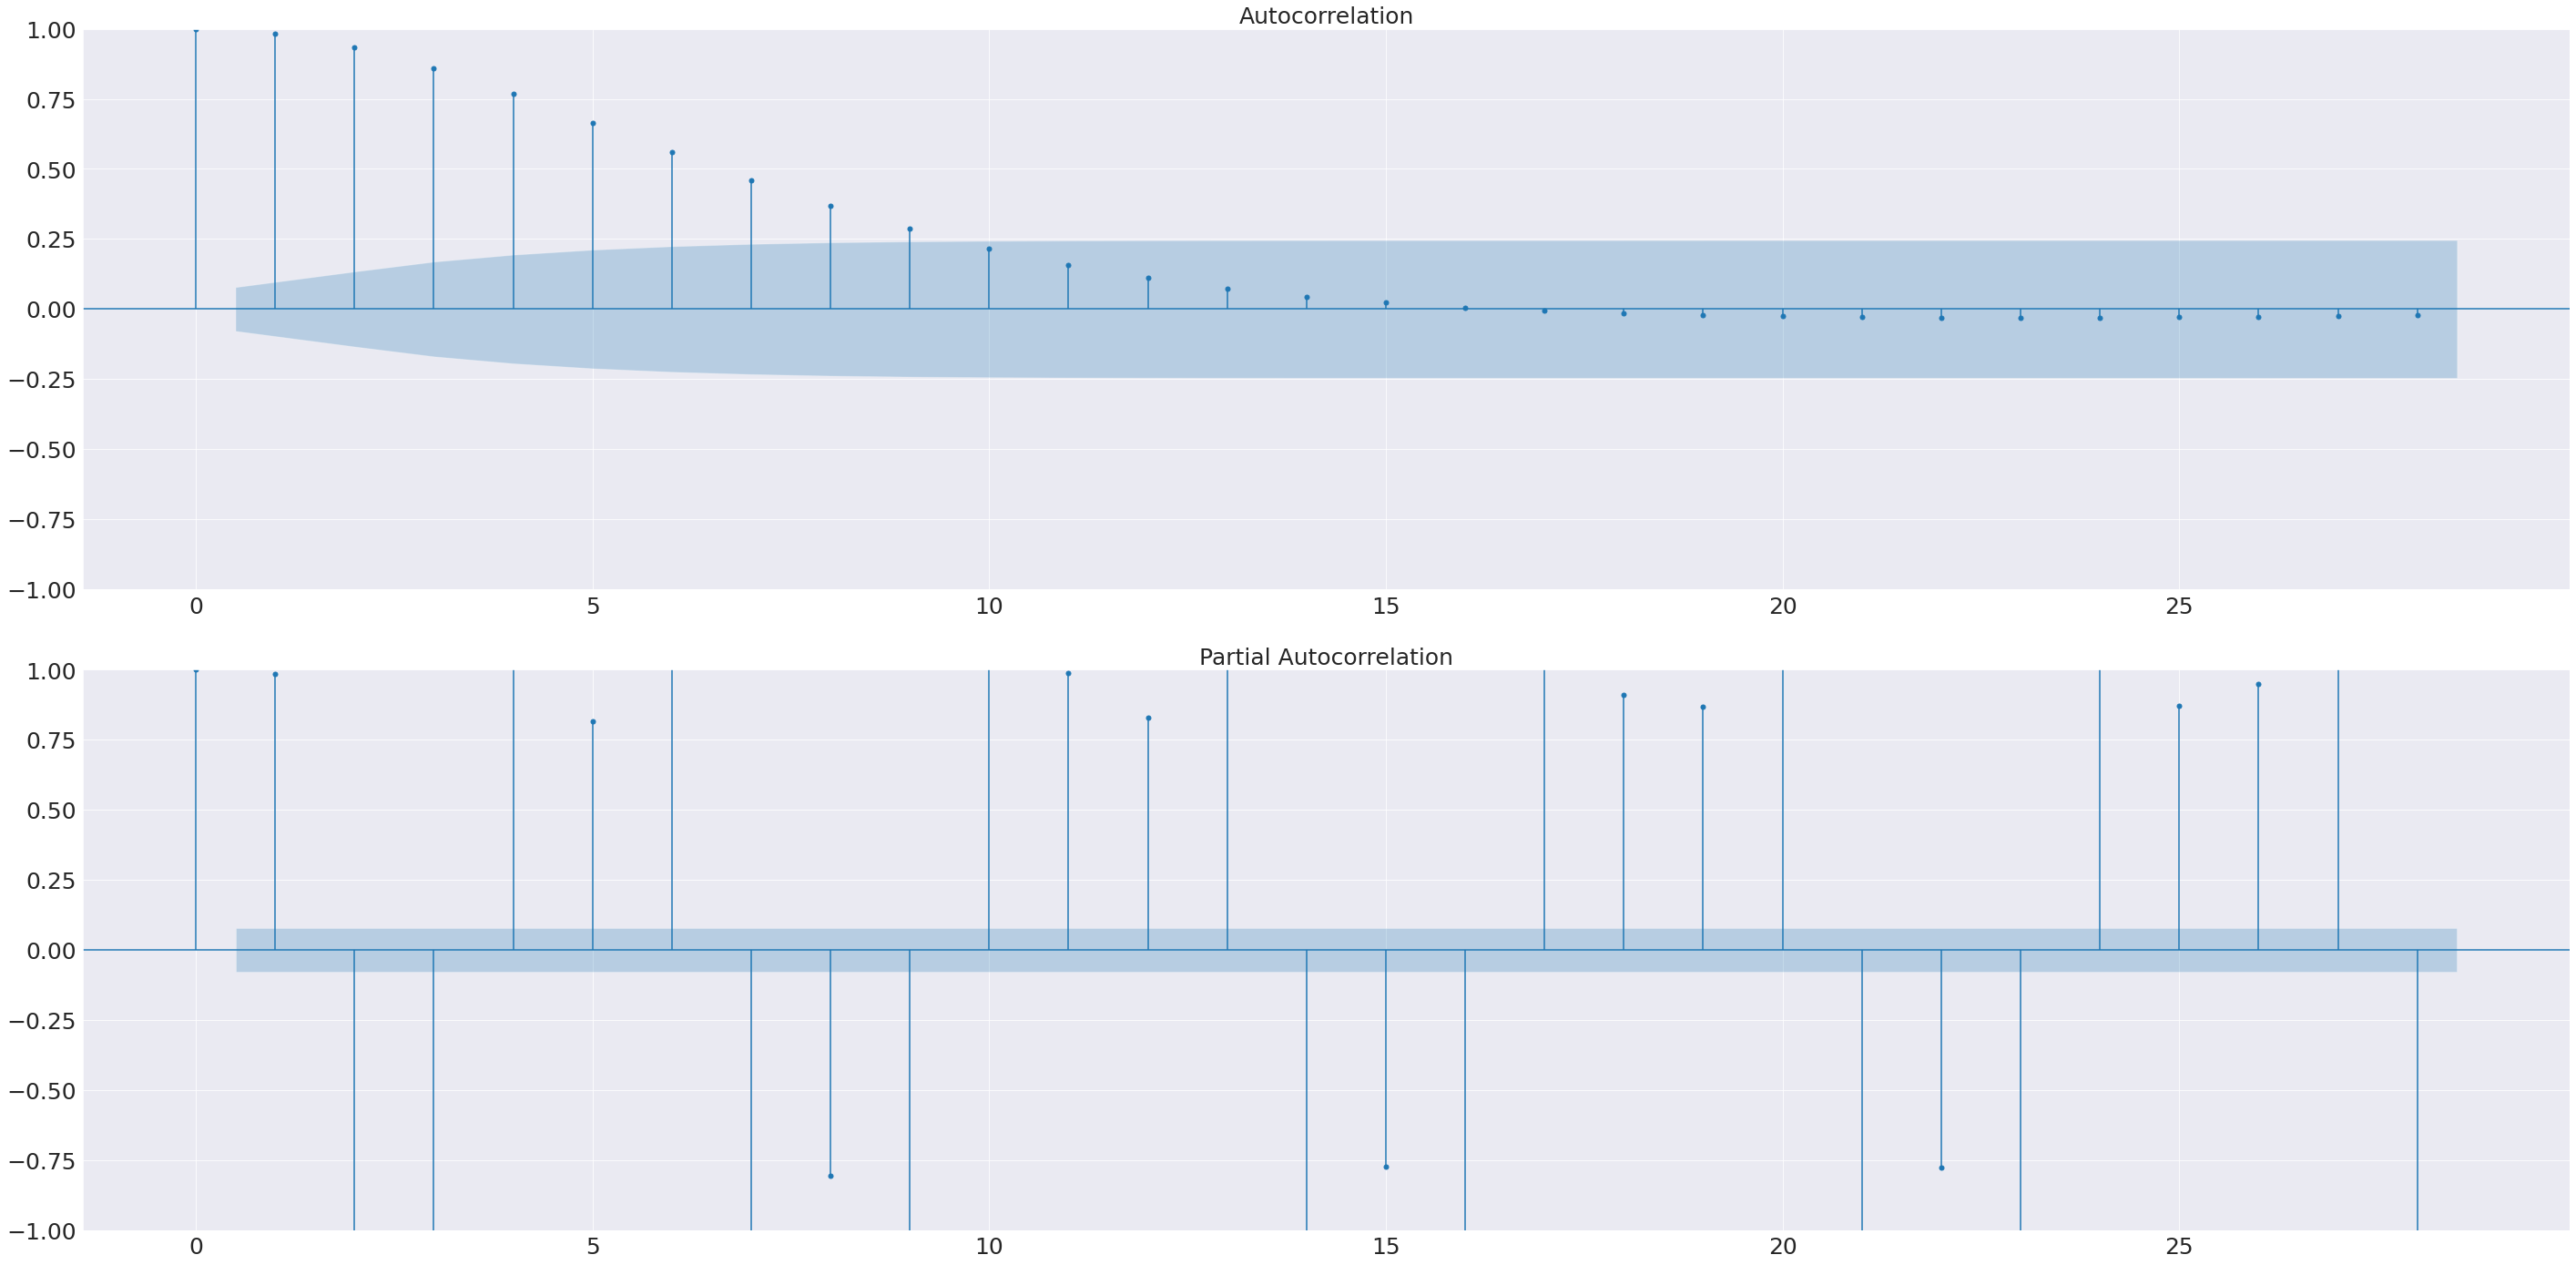

In [17]:
fig, ax = plt.subplots(2, figsize=(40,20))
plot_acf(df2['y'], ax=ax[0])  # Plot the ACF on the first subplot
plot_pacf(df2['y'], ax=ax[1])  # Plot the PACF on the second subplot
plt.tight_layout()
plt.show()

### The ACF suggests the AR order should be less than 10. What about the PACF plot??

## Order determination through the information matrix

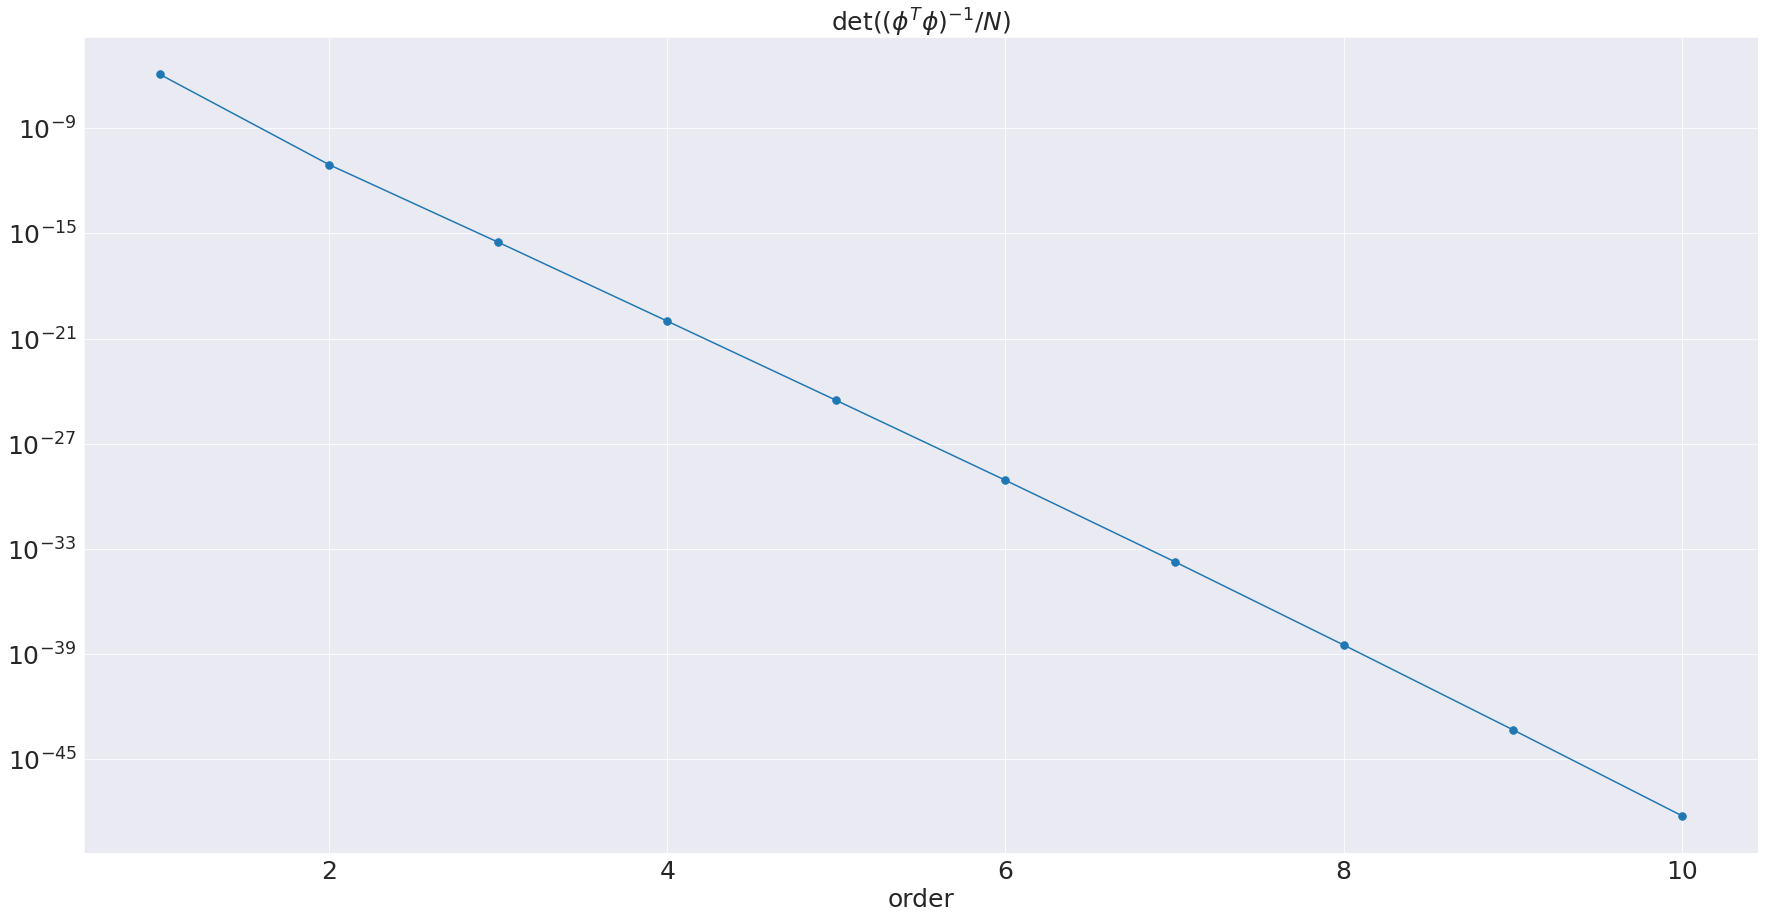

In [20]:
# def construct_info_matrix(y, u, ny, nu):
#     # Make sure y and u are numpy arrays
#     y = np.array(y)
#     u = np.array(u)
#
#     N = len(y)
#     assert len(u) == N, "Input and output must be the same length"
#
#     # Initialize an empty matrix
#     Phi = np.empty((N, ny + nu + 1))
#
#     # Loop over each row of the matrix
#     for t in range(N):
#         # Autoregressive part
#         for i in range(ny):
#             Phi[t, i] = y[t-i-1] if t-i-1 >= 0 else 0
#
#         # Exogenous part
#         for i in range(nu + 1):
#             Phi[t, i + ny] = u[t - i] if t - i >= 0 else 0
#
#     return Phi

def construct_info_matrix(y, u, order):
    ys = [np.roll(y,i) for i in range(order)]
    us = [np.roll(u,i) for i in range(order)]
    return np.vstack(ys+us).T[order-1:]

lag_max = 10
order = []
for i in range(1,lag_max+1):
    phi = construct_info_matrix(df2['y'], df2['u'], i)
    order.append(np.linalg.det(np.linalg.inv(phi.T @ phi) / (i*2)))

f = plt.figure(figsize=(30,15))
plt.title(r'$\det ((\phi^T\phi)^{-1} / N)$')
plt.xlabel('order')
plt.semilogy(range(1,lag_max+1),order, marker='.', markersize=15)
plt.grid(True)
plt.show()

### The drop is most significant between the 1st and 2nd order which suggests the 1order model

# PRELIMINARY ESTIMATION

## Compute step response function (transfer function) - a FIR model

[-0.006715373471743783, 0.9937322119761787, -1.0068578410182958]


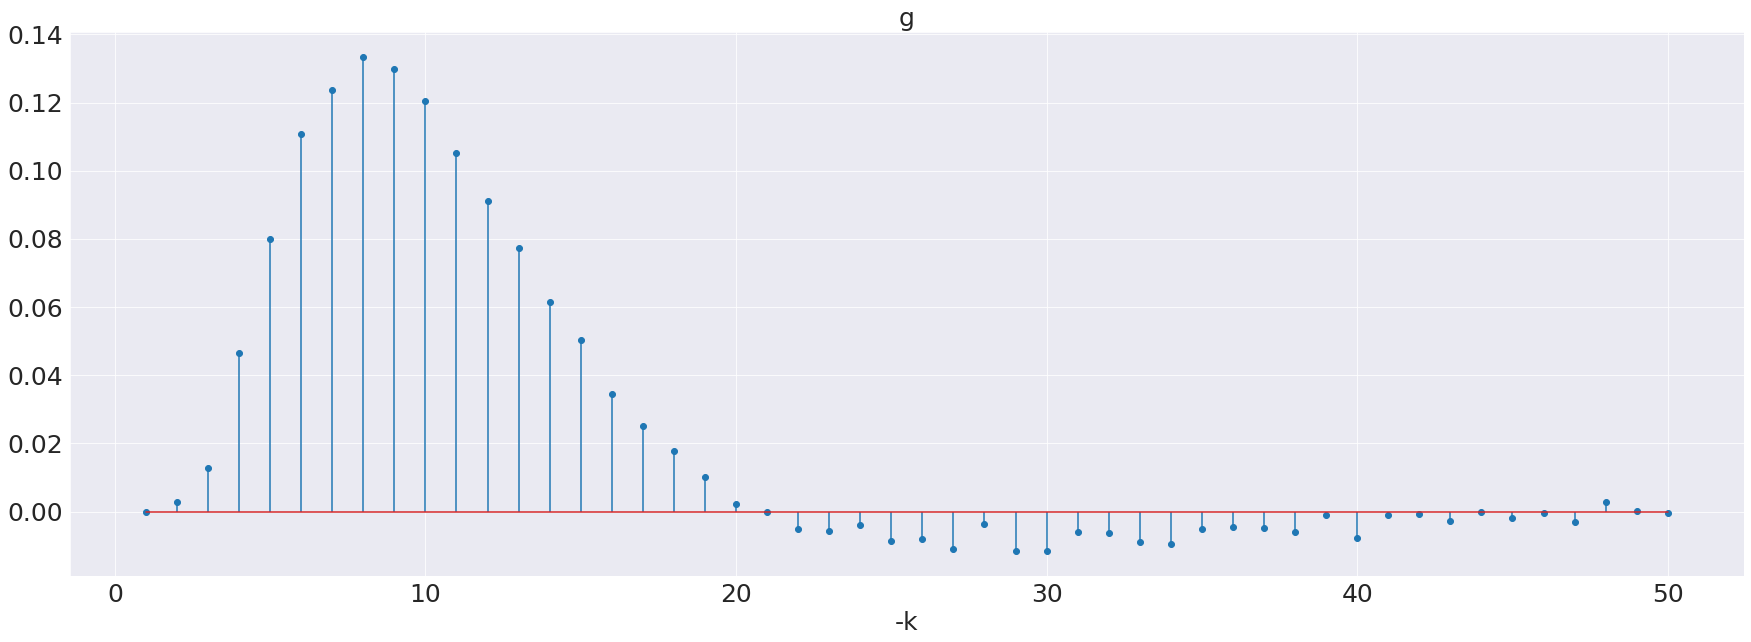

In [21]:
lags = 50

u1_set = list(set(df1['u']))
print(u1_set)
if len(u1_set) != 3:
    raise ValueError('len not equal 3')

u1_max = np.max(u1_set)
u1_med = np.median(u1_set)
u1_min = np.min(u1_set)

u1_bin = []
for i in df1['u']:
    if i == u1_max: u1_bin.append(1)
    if i == u1_med: u1_bin.append(0)
    if i == u1_min: u1_bin.append(-1)

# Find the locations of the rising edges in the input
rising_indices = np.where(np.diff(u1_bin) == 2)[0] + 1
falling_indices = np.where(np.diff(u1_bin) == -2)[0] + 1

impulse_responses_rising = np.asarray([df1['y'][i:i+lags] for i in rising_indices][1:]) # exclude the first one because different (starting from zero)
impulse_responses_falling = np.asarray([-df1['y'][i:i+lags] for i in falling_indices][:-1]) # exclude the last one because it is shorter
impulse_responses = np.vstack([impulse_responses_rising,impulse_responses_falling])

# delete a response that does not look right
impulse_responses = np.delete(impulse_responses,10,axis=0)

# average responses (we only care about the gradient (except for g_0)
impulse_response = (np.mean(impulse_responses, axis=0))

# works better if we set it to zero rather than to np.mean(impulse_responses_rising, axis=0)[0] / 2
g = [0]

for i in range(1, len(impulse_response)):
    g.append((impulse_response[i]-impulse_response[i-1])/2) # /2 cuz steps size=2 (from -1 to 1)

# Plotting the Impulse Response
fig, axn = plt.subplots(1,1,figsize=(30,10))
plt.stem(np.arange(1,lags+1),g)
plt.title('g')
plt.xlabel('-k')
plt.grid(True)
plt.show()

## Reconstruct output signal from the step response function

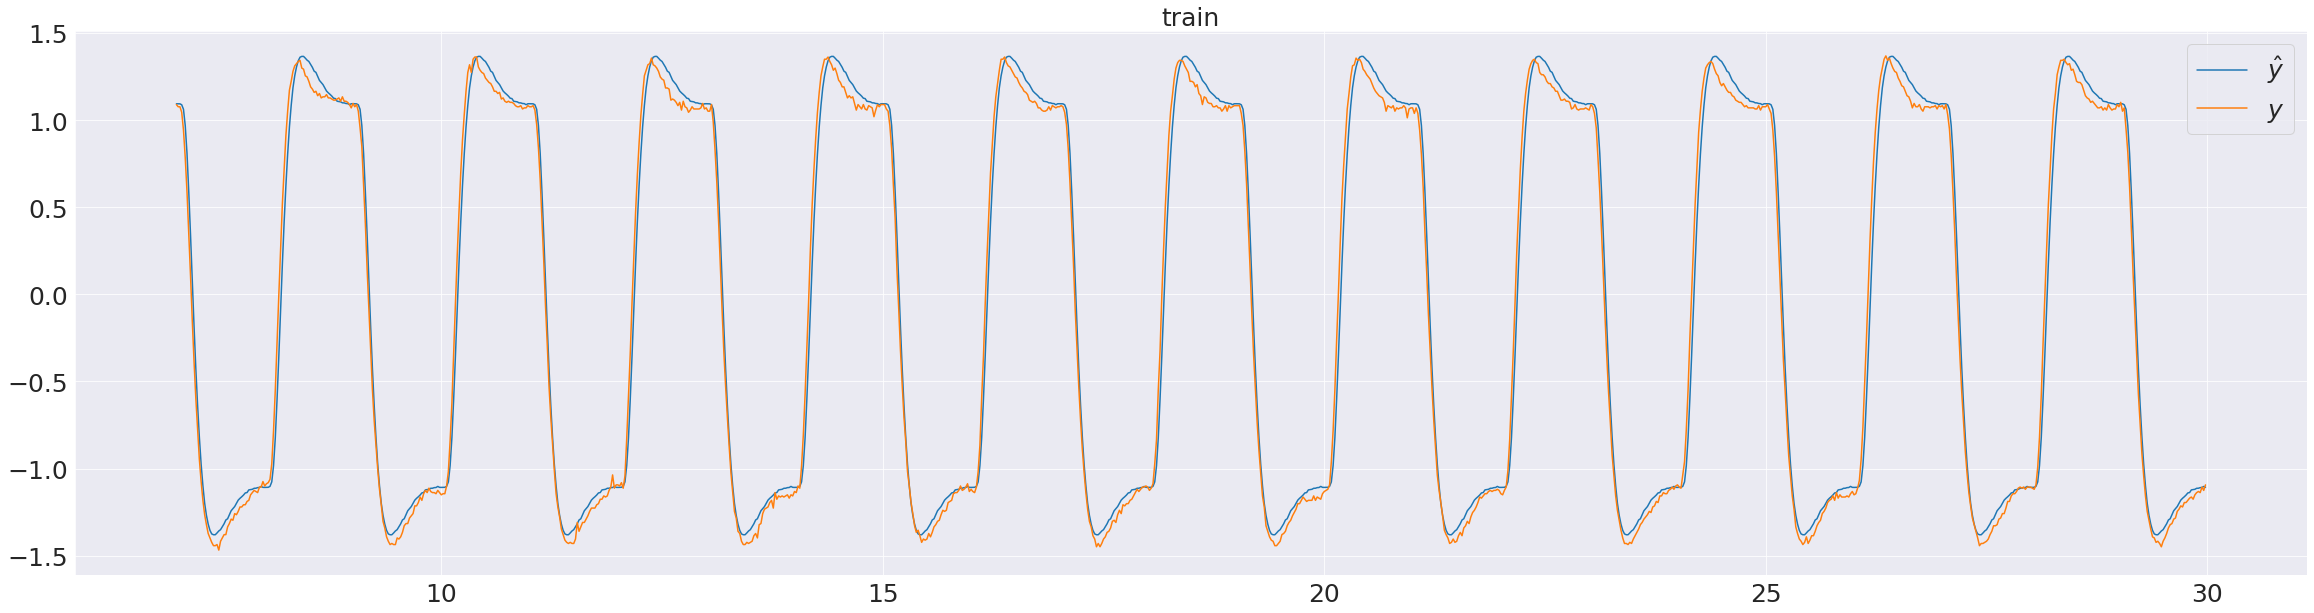

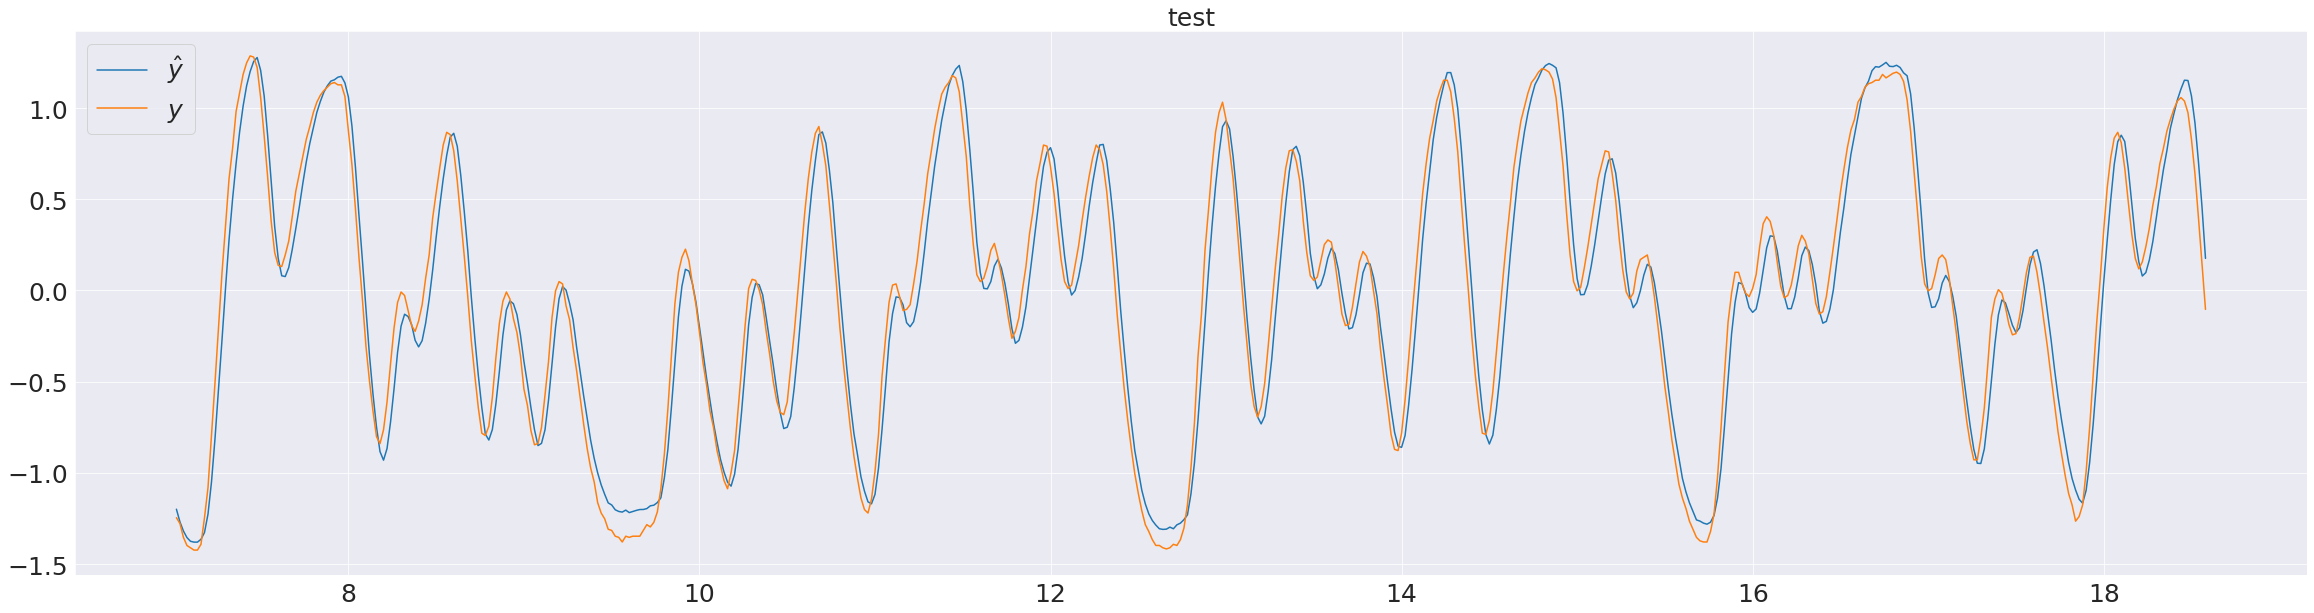

In [10]:
# for train of pulses
y_rec = np.zeros(len(df1['u'])-lags) # y reconstructed

g_rev = g[::-1] # step response function reversed

for i in range(len(df1['y'])-lags):
    y_rec[i] = np.sum(g_rev * df1['u'][i:i+lags])

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.plot(df1['time'][lags:], y_rec, label=r'$\hat{y}$')
plt.plot(df1['time'][lags:], df1['y'][lags:], label=r'$y$')
plt.grid(True)
plt.title('train')
plt.legend()
plt.show()

#----------------------------------------------

#for PRBS
y_rec = np.zeros(len(df2['u'])-lags) # y reconstructed

g_rev = g[::-1] # step response function reversed

for i in range(len(df2['y'])-lags):
    y_rec[i] = np.sum(g_rev * df2['u'][i:i+lags])

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.plot(df2['time'][lags:], y_rec, label=r'$\hat{y}$')
plt.plot(df2['time'][lags:], df2['y'][lags:], label=r'$y$')
plt.grid(True)
plt.title('test')
plt.legend()
plt.show()

The step response (transfer function) manages to capture the shape of the response for the train of pulses input signal, as well for the PRBS which is here used as a test.

# Estimate transfer function from corrrelation function (Ljung, pg. 170) - a FIR model

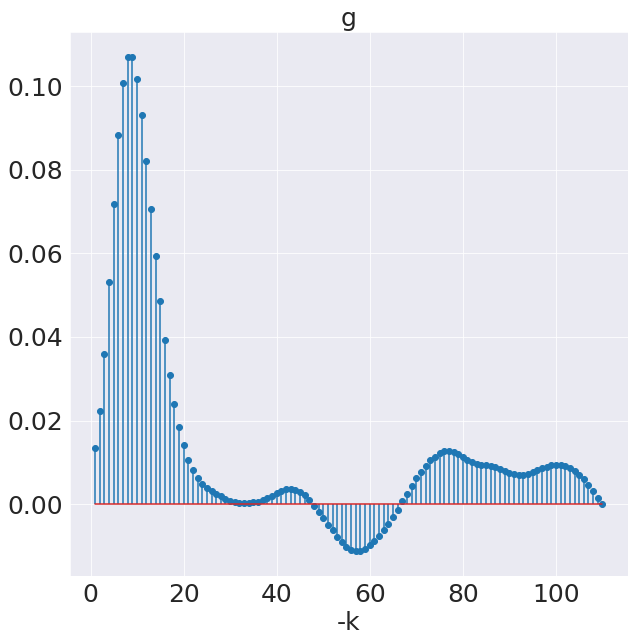

In [11]:
m = np.sum([1 for i in df2['u'] if i==np.max(list(set(df2['u'])))])
M = 110 # of delays
N = M # to be able to easy invert the matrix equation

def Rab(a,b):
    a, b = np.asarray(a), np.asarray((b))
    if len(a) != len(b): raise ValueError
    N = len(a)
    Ryu = np.zeros(N)
    for tau in range(N):
        c = 0
        for k in range(N-tau):
            c += a[k+tau] * b[k]
        Ryu[tau] = 1 / (N-tau) * c
    return Ryu

Ryu = Rab(df2['y'],df2['u'])
Ru = Rab(df2['u'],df2['u'])

Ryu = Ryu[:N]
Ru_mat = np.ones((N,M)) * m * (m-1) / (N * (N-1))
for mi in range(M-1):
    Ru_mat[mi,mi+1] *= (N-1) / (m-1)

#np.set_printoptions(threshold=np.inf)

g = np.linalg.solve(Ru_mat,Ryu)

# tweaks (don't understand why it works (also looks) better if I do this). Maybe a bug in the code
g[0] = 0.00
g = - (g)
g = np.roll(g,-1)

# Plotting the Impulse Response
fig, axn = plt.subplots(1,1,figsize=(10,10))
plt.stem(np.arange(1,M+1),g)
plt.title('g')
plt.xlabel('-k')
plt.grid(True)
plt.show()

# Reconstruct output signal from the ('correlation') response function

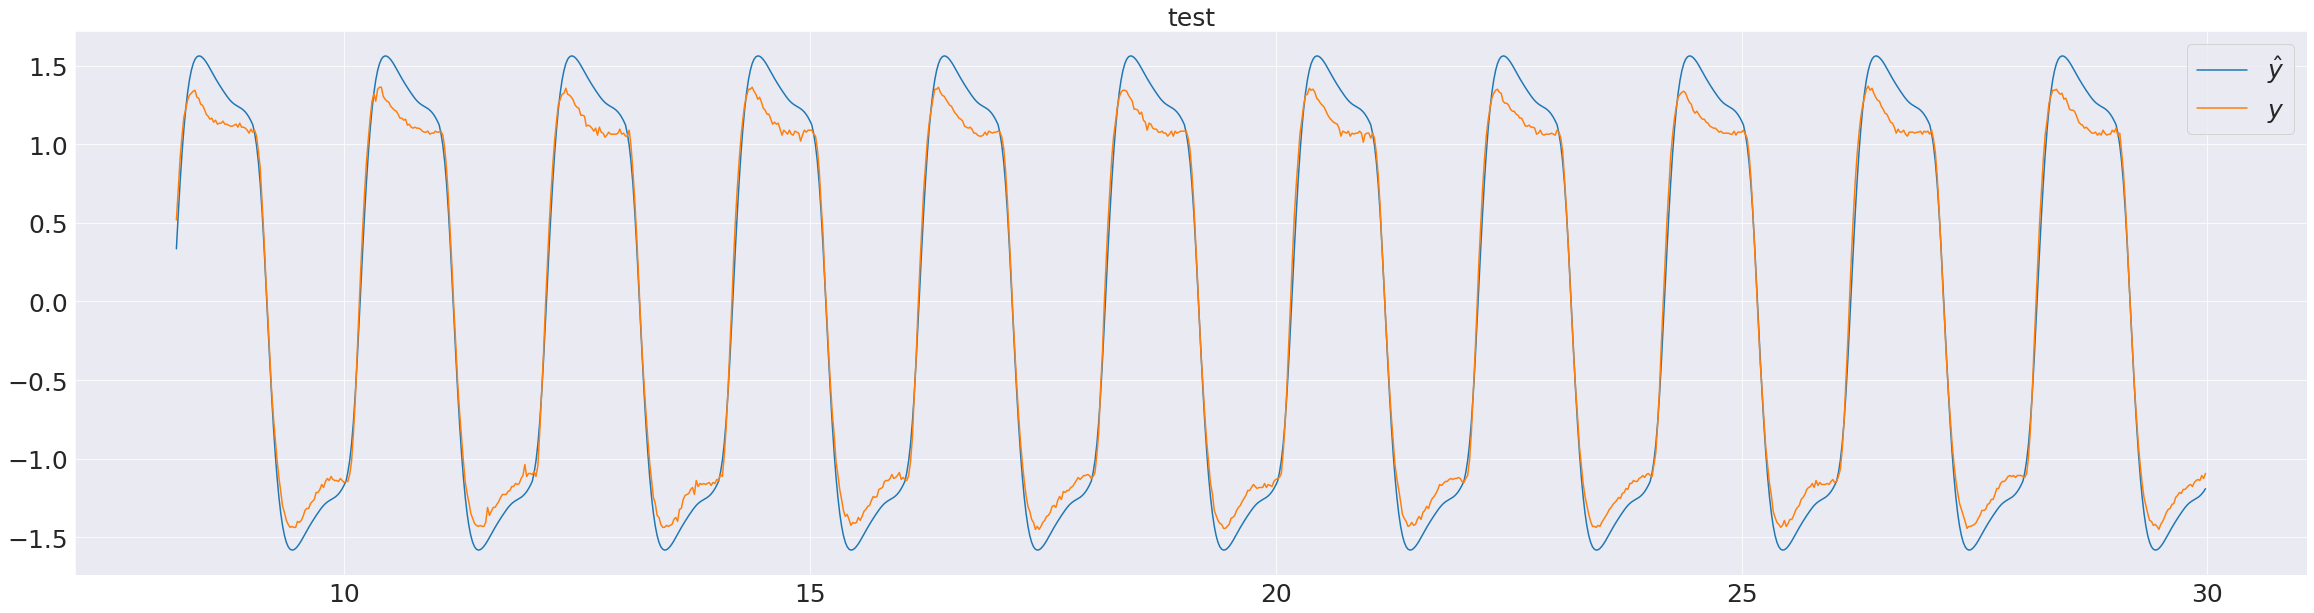

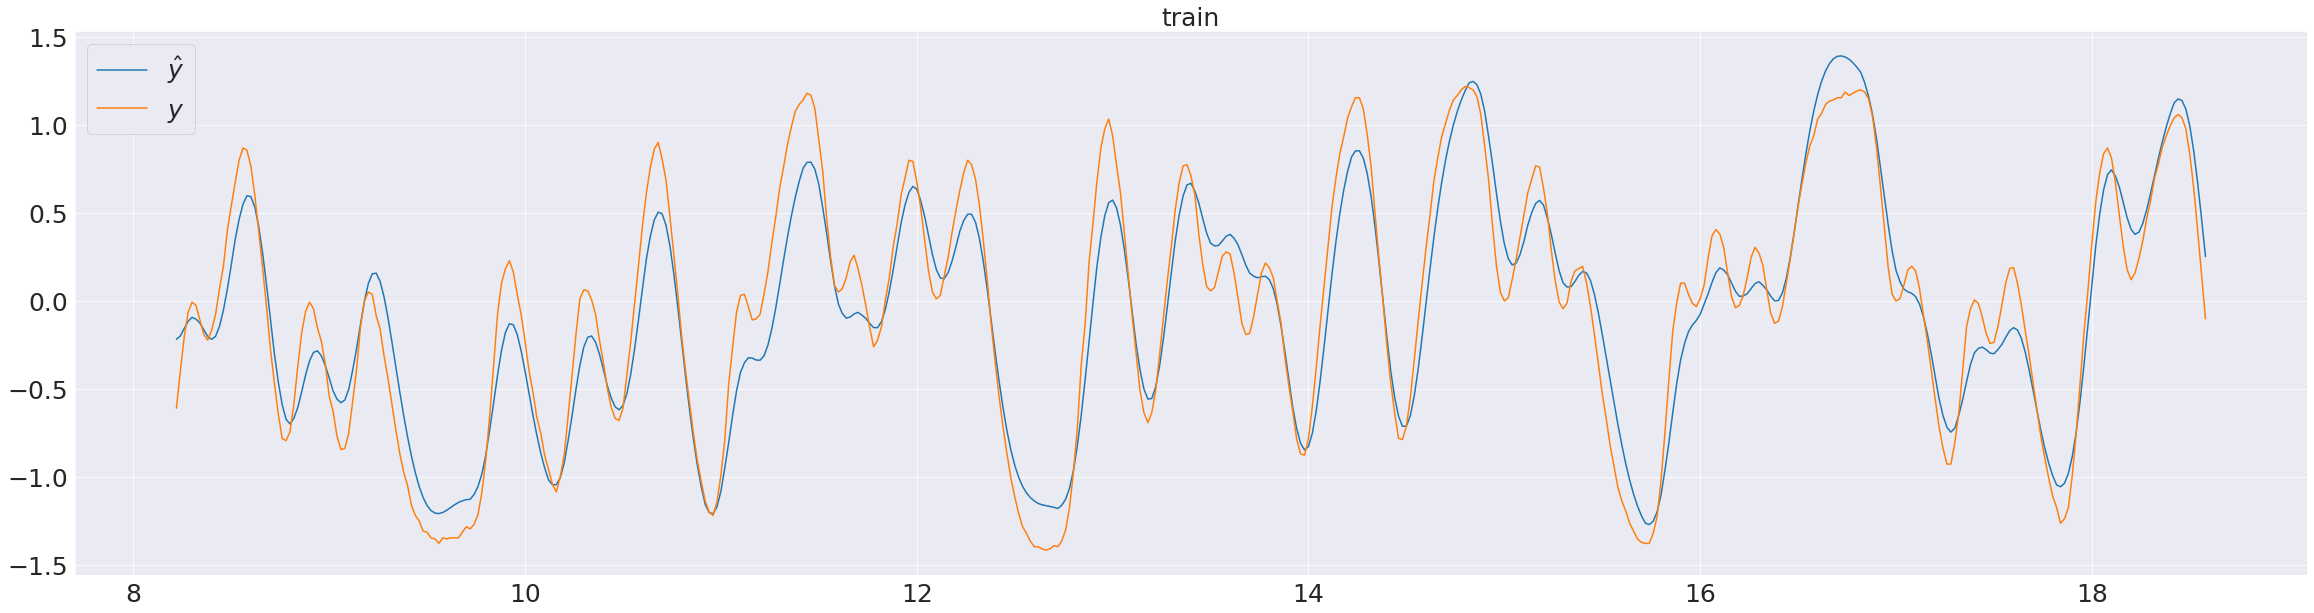

In [12]:
g_rev = g[::-1] # step response function

#----------------------------------------------

# for train of pulses
y_rec = np.zeros(len(df1['u'])-M) # y reconstructed

for i in range(len(df1['y'])-M):
    y_rec[i] = np.sum(g_rev * df1['u'][i:i+M])

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.plot(df1['time'][M:], y_rec, label=r'$\hat{y}$')
plt.plot(df1['time'][M:], df1['y'][M:], label=r'$y$')
plt.grid(True)
plt.title('test')
plt.legend()
plt.show()

#----------------------------------------------

#for PRBS
y_rec = np.zeros(len(df2['u'])-M) # y reconstructed

for i in range(len(df2['y'])-M):
    y_rec[i] = np.sum(g_rev * df2['u'][i:i+M])

fig, axn = plt.subplots(1,1,figsize=(40,10))
plt.plot(df2['time'][M:], y_rec, label=r'$\hat{y}$')
plt.plot(df2['time'][M:], df2['y'][M:], label=r'$y$')
plt.grid(True)
plt.title('train')
plt.legend()
plt.show()

For the time delay of M=90 samples, the transfer function, reconstructed from the correlation functions $R_{\epsilon}$ and $R_{\epsilon,u}$, applied on the PRBS manages to capture the step response quite well, however, for the PRBS it performs worse than the transfer function obtained from the step response. For number of delays M=110, the mentioned transfer function captures PRBS 'quite well', but in return performs much worse on the train of pulses signal. For some reason, the first coefficient g(0) has to be set to zero for the transfer function to make sense (both for step and correlation case). For the transfer function g obtained from correlation functions, also g=-g must be applied (code bug?). It also works better if we make a transformation $g_i=g_{i+1}$ where $i$ is periodic under mod M.

# -----------------------------------------------------------------------------------------------------------------

# AR(MA)X (just an example - not working good.)

/home/kreljo/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kreljo/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/kreljo/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  626
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1507.248
Date:                Mon, 17 Jul 2023   AIC                          -2998.497
Time:                        11:20:30   BIC                          -2962.982
Sample:                             0   HQIC                         -2984.698
                                - 626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.150      0.250      -0.000       0.002
y_lag1         1.7213      0.006    298.325      0.000       1.710       1.733
y_lag2        -0.7660      0.006   -138.406      0.0

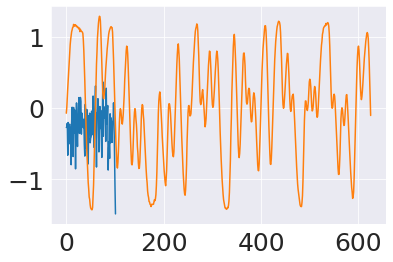

ValueError: 

In [13]:
# simple ARX model

df22 = copy.deepcopy(df2)

order_u = 3 # fixed as the length of the input
order_y = 2
order_e = 0


for i in range(1, order_u + 1):
    df22[f'u_lag{i}'] = df22['u'].shift(i)
for i in range(1, order_y + 1):
    df22[f'y_lag{i}'] = df22['y'].shift(i)

# # create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, order_u+1)]
lagged_y = ['y_lag'+str(i) for i in range(1, order_y+1)]

df22 = df22.dropna() # shorten the data because of NaNs (that come from lags)

endog22 = df22['y']
exog22 = df22[lagged_y+lagged_u]

model = ARIMA(endog22, order=(1,0,order_e), exog=exog22)
model_fit = model.fit()#start_params=start_params)
params = model_fit.params
print(model_fit.summary())

print(df22[lagged_y+lagged_u][:1])

def simulate(ylags0, ulags, steps):
    ylags0 = np.asarray(ylags0)
    ulags  = np.asarray(ulags)

    ylags = ylags0

    for i in range(steps):
        y_next = model.simulate(params, 1, exog=np.hstack((ylags[:order_y].reshape(-1),np.asarray(ulags[i:i+1]).reshape(-1))))
        ylags = np.concatenate((np.asarray([y_next]).reshape(-1),ylags.reshape(-1)))
        print(ylags)

    return ylags

yhat = simulate(df22[lagged_y][:1],df22[lagged_u],100)
print(yhat)
plt.plot(np.asarray(yhat*10))
plt.plot(np.asarray(df22['y']))
plt.show()



raise ValueError

df22['y_s'] = model.simulate(params, len(endog22), exog=exog22)

fig, axn = plt.subplots(2,1,figsize=(40,20))
title = 'ARMAX u(t=...,-{}), y(t=...,-{}), e(t=...,-{})'.format(order_u,order_y,order_e)
fig.suptitle(title)
axn[0].plot(df22['time'], df22['y_s'], label=r'$\hat{y}$')
axn[0].plot(df22['time'], df22['y'], label=r'$y$')
axn[0].set_title('train')
axn[0].legend()

#------------------------------------------
# simulate on train of pulses

# only allowd to simulate at once for the amount of steps used for original fit
simulation_time = len(df22['u'])

df11 = copy.deepcopy(df1)

for i in range(1, order_u + 1):
    df11[f'u_lag{i}'] = df11['u'].shift(i)
for i in range(1, order_y + 1):
    df11[f'y_lag{i}'] = df11['y'].shift(i)

exog11 = df11[lagged_y+lagged_u]

df11['y_s'] = model.simulate(params, simulation_time, exog=exog11)#, initial_state=df11['y'][:1])

axn[1].plot(df11['time'], df11['y_s'], label=r'$\hat{y}$')
axn[1].plot(df11['time'], df11['y'], label=r'$y$')
axn[1].set_title('test')
axn[1].legend()
plt.savefig('figs/{}.eps'.format(title))
plt.show()


In [ ]:
# # VARMAX zajebava neki
#
# # simple ARX model using statsmodels.tsa.arima.model.ARIMA
#
# df22 = copy.deepcopy(df2)
#
# # orders of fuunctions corresponding to u, y and e
# order_u = 3 #len(g)
# order_y = 3
# order_e = 0
#
#
# # to account for all order_u lags of the exogenous variable, new lagged arrays
# # must be created (a feature of statsmodels.tsa.arima.model.ARIMA)(
# for i in range(1, order_u + 1):
#     df22[f'u_lag{i}'] = df22['u'].shift(i)
# for i in range(1, order_y + 1):
#     df22[f'y_lag{i}'] = df22['y'].shift(i)
#
# df22 = df22.dropna() # shorten the data because of NaNs (that come from lags)
#
# # create a list of labels
# lagged_u = ['u_lag'+str(i) for i in range(1, order_u+1)]
# lagged_y = ['y_lag'+str(i) for i in range(1, order_y+1)]
#
# endog22 = df22[['y','y_lag1']]
# exog22 = df22[lagged_u]
#
#
# model = VARMAX(endog=endog22, order=(order_y,order_e), exog=exog22)
# model_fit = model.fit(disp=False)
#
# params = model_fit.params
# print(model_fit.summary())
#
# yhat = model.simulate(params=params, nsimulations=len(endog22), exog=np.asarray(exog22))
# df22['y_s'] = yhat['y']
#
#
# fig, axn = plt.subplots(2,1,figsize=(40,20))
# title = 'ARMAX u(t=...,-{}), y(t=...,-{}), e(t=...,-{})'.format(order_u,order_y,order_e)
# fig.suptitle(title)
# axn[0].plot(df22['time'], df22['y_s'], label=r'$\hat{y}$')
# axn[0].plot(df22['time'], df22['y'], label=r'$y$')
# axn[0].set_title('train')
# axn[0].legend()
# plt.show()
#
#
#
# raise ValueError
#
# #------------------------------------------
# # simulate on train of pulses
#
# # only allowd to simulate at once for the amount of steps used for original fit
# simulation_time = len(df22['u'])
#
# df11 = copy.deepcopy(df1)
# for i in range(1, order_u + 1):
#     df11[f'u_lag{i}'] = df11['u'].shift(i)
# df11 = df11.iloc[order_u:]
#
# endog_ = df11['y']
# exog_ = df11[[f'u_lag{i}' for i in range(1, 1 + order_u)]]
#
#
#
# df11['y_s'] = model.simulate(params, nsimulations=simulation_time, exog=exog_)# initial_state=df11['y'][:order_y])
#
# axn[1].plot(df11['time'], df11['y_s'], label=r'$\hat{y}$')
# axn[1].plot(df11['time'], df11['y'], label=r'$y$')
# axn[1].set_title('test')
# axn[1].legend()
# plt.savefig('figs/{}.eps'.format(title))
# plt.show()

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt

# Define systems
sys1 = signal.TransferFunction([1], [1, 1])  # 1st order system
sys2 = signal.TransferFunction([1], [1, 1, 1])  # 2nd order system
sys3 = signal.TransferFunction([1], [1, 1, 1, 1])  # 3rd order system

systems = [sys1, sys2, sys3]
titles = ['1st Order System', '2nd Order System', '3rd Order System']

# Plot the Bode diagrams
for sys, title in zip(systems, titles):
    w, mag, phase = signal.bode(sys)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.semilogx(w, mag)  # Bode magnitude plot
    plt.title(title)
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Magnitude [dB]')

    plt.subplot(1, 2, 2)
    plt.semilogx(w, phase)  # Bode phase plot
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Phase [degrees]')

    plt.tight_layout()
    plt.show()